<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 3: Simulated Annealing

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

In [1]:
# package list
import tkinter as tk
from tkinter import filedialog
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# Simulated Annealing
TEMPERATURE = 100000
COOLING_RATIO = 0.90
SUB_STEPS = 500
np.random.seed(0)
n_b_cnt=0
avg_n_b=0

# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

# First City Index
FIRST_IDX = 0

# Step 1. Data Loading

In [2]:
def fileloader():
    # Data loading
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename()
    if file_path == '':
        raise Exception('Cannot load a data file')
    root.destroy()
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        coord_split = item.split()
        coord_list[idx, 0] = int(coord_split[1])
        coord_list[idx, 1] = int(coord_split[2])

    return coord_list

# Step 2. Initialization

In [3]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 3. SA (2-opt search)

In [4]:
def two_opt_swap(path_map, path, steps):
    cnt_cities = path_map.shape[0]
    best_cost = float('inf')
    for i in range(steps):
        curr_path = path.copy()
        # Select two indices for flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))
        if sel_idx[1] - sel_idx[0] <= 1:
            continue
        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        
        
        curr_cost = cost_arr.sum()
        
        if curr_cost < best_cost:
            best_path = curr_path.copy()
            best_cost = curr_cost
          
    
    return best_path, best_cost

In [5]:
def simulated_annealing(path_map, path):
    best_path = path.copy()
    best_cost = path_cost(path_map, best_path).sum()

    global TEMPERATURE,avg_n_b,n_b_cnt
    #should change value data1 : 6.48, data2 : 33.57, data3 : 34.65
    while TEMPERATURE >= 34.65:
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_STEPS)
        
        if new_cost < best_cost:
            best_path = new_path
            best_cost = new_cost
        else:
            prob = np.exp(-(new_cost - best_cost) / float(TEMPERATURE))
            avg_n_b+=new_cost-best_cost
            n_b_cnt+=1
            if prob > np.random.rand(1):
                best_path = new_path
                best_cost = new_cost
            TEMPERATURE = TEMPERATURE * COOLING_RATIO

    return best_path, best_cost

# Main

Execution Time: 57.920233488082886
Path: [0, 37, 36, 35, 34, 33, 32, 31, 30, 29, 27, 28, 26, 25, 1, 49, 70, 75, 83, 103, 153, 172, 178, 186, 215, 221, 281, 288, 289, 236, 237, 238, 239, 240, 291, 290, 317, 371, 338, 370, 337, 316, 368, 360, 395, 400, 401, 407, 412, 442, 441, 440, 439, 438, 437, 443, 444, 445, 446, 447, 448, 449, 483, 482, 502, 517, 539, 538, 516, 501, 500, 537, 499, 536, 535, 515, 498, 481, 436, 531, 417, 489, 484, 540, 559, 563, 565, 661, 740, 687, 710, 750, 754, 729, 677, 695, 668, 638, 645, 605, 606, 655, 656, 608, 607, 569, 556, 557, 739, 768, 738, 684, 659, 615, 616, 617, 614, 613, 612, 611, 610, 609, 657, 658, 683, 707, 737, 736, 706, 682, 681, 735, 705, 704, 734, 767, 766, 807, 808, 809, 810, 811, 812, 778, 813, 814, 815, 816, 776, 817, 818, 773, 772, 771, 770, 769, 749, 686, 741, 300, 375, 383, 733, 1386, 1399, 1388, 1394, 1286, 1275, 1301, 1325, 1328, 1308, 1334, 1314, 1370, 1319, 1373, 1398, 1322, 1345, 1376, 1346, 1377, 1378, 1347, 1324, 1379, 1404, 1380, 13

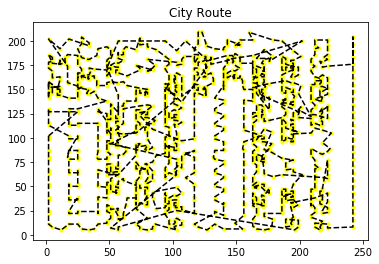

In [6]:
# Initialization ###############
initialize = initialize_greedy
#initialize = initialize_random
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2
path_map, path = initialize(coord_list, FIRST_IDX)

# Step 3
best_path, best_cost = simulated_annealing(path_map, path)

if PLOT_MODE:
    figure, ax = plt.subplots()
    plt.scatter(coord_list[:, 0], coord_list[:, 1], c='yellow', s=10)
    plt.title('City Route')
    coord_path = coord_list
    coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
    coord_path[:, :] = coord_path[best_path, :]
    lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
    figure.canvas.draw()

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))
print("total : "+str(avg_n_b)+"cnt : "+str(n_b_cnt)+"AVG n-b : "+str(avg_n_b/n_b_cnt))